In [1]:
!pip install torchvision
!pip install captum

     |████████████████████████████████| 5.7MB 3.7MB/s 


# Base CONV

In [2]:
import torch
import torchvision
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [10]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw





Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


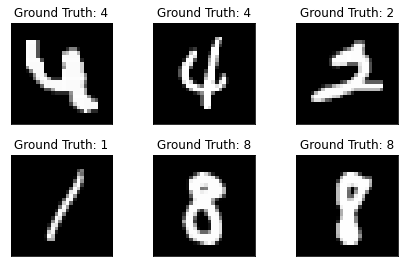

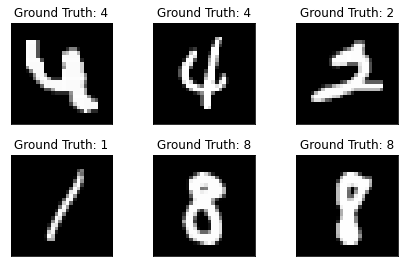

In [4]:
import matplotlib.pyplot as plt
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from captum.attr import GuidedGradCam


In [12]:
class View(nn.Module):

    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

class ch_attention(nn.Module):

    def __init__(self, n_ch, r=16):
        super(ch_attention, self).__init__()
        layers = []
        layers += [nn.AdaptiveAvgPool2d((1,1)),
                   View(-1),
                   nn.Linear(in_features=n_ch, out_features=n_ch//r, bias=False),
                   nn.BatchNorm1d(n_ch//r),
                   nn.ReLU(True),
                   nn.Linear(in_features=n_ch//r, out_features=n_ch)]
        self.layers = nn.Sequential(*layers) 
    def forward(self, x):
        return self.layers(x).unsqueeze(2).unsqueeze(3).expand_as(x) 
    
class spatial_attention(nn.Module):

    def __init__(self, n_ch, r=16, dilation=4):
        super(spatial_attention, self).__init__()
        layers = []
        layers += [nn.Conv2d(in_channels=n_ch, out_channels=n_ch//r, kernel_size=1, bias=False),
                   nn.BatchNorm2d(n_ch//r),
                   nn.ReLU(True),
                   nn.Conv2d(in_channels=n_ch//r, out_channels=n_ch//r, kernel_size=3, padding=dilation, dilation=dilation, bias=False),
                   nn.BatchNorm2d(n_ch//r), 
                   nn.ReLU(True),
                   nn.Conv2d(in_channels=n_ch//r, out_channels=n_ch//r, kernel_size=3, padding=dilation, dilation=dilation, bias=False),
                   nn.BatchNorm2d(n_ch//r),
                   nn.ReLU(True),
                   nn.Conv2d(in_channels=n_ch//r, out_channels=1, kernel_size=1)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x).expand_as(x)

class BAM(nn.Module):

    def __init__(self, n_ch, r=16, dilation=4):
        super(BAM, self).__init__()
        self.channel_att = ch_attention(n_ch, r)
        self.spatial_att = spatial_attention(n_ch, r, dilation)

    def forward(self, x):
        ch_out = self.channel_att(x)
        sp_out = self.spatial_att(x)
        out = 1 + torch.sigmoid(ch_out*sp_out)
        return out * x

class BAM_spatial(nn.Module):

    def __init__(self, n_ch, r=16, dilation=4):
        super(BAM_spatial, self).__init__()

        self.spatial_att = spatial_attention(n_ch, r, dilation)

    def forward(self, x):

        sp_out = self.spatial_att(x)
        out = 1 + torch.sigmoid(sp_out)
        return out * x




In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [14]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [15]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [30]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [16]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [17]:
network

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [18]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


KeyboardInterrupt: ignored

In [ ]:
test_losses[0:4]


[2.3064828125, 0.23145717163085938, 0.13517356414794923, 0.10196828842163086]

Text(0, 0.5, 'negative log likelihood loss')

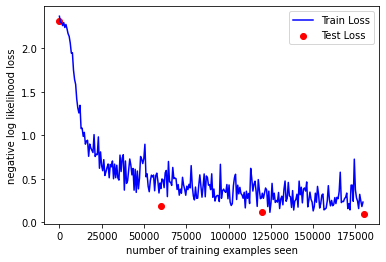

In [14]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses[0:4], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


In [ ]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
def saliency(id,network):
  network.eval()

  # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
  X=test_loader.dataset[id][0].reshape(1,1,28,28)
  X.requires_grad_()
  print(test_loader.dataset[id][1])
  '''
  forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
  and we also don't need softmax, we need scores, so that's perfect for us.
  '''

  scores = network(X)

  # Get the index corresponding to the maximum score and the maximum score itself.
  score_max_index = scores.argmax()
  score_max = scores[0,score_max_index]

  '''
  backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
  score_max with respect to nodes in the computation graph
  '''
  score_max.backward()

  '''
  Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
  R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
  across all colour channels.
  '''
  saliency, _ = torch.max(X.grad.data.abs(),dim=1)
  return saliency[0]


plot_saliencies=[1,100,200,1000,3000,4000]
i=1

# code to plot the saliency map as a heatmap
for s in plot_saliencies:
  plt.subplot(2,3,i)
  plt.imshow(saliency(s,network), cmap=plt.cm.hot)

  plt.axis('off')
  i+=1

plt.show()

NameError: ignored

In [ ]:
network

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
guided_gc=GuidedGradCam(network,network.conv2)

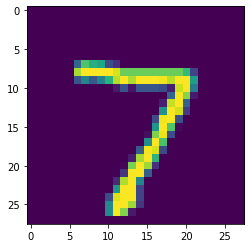

In [ ]:
plt.imshow(test_loader.dataset[0][0].reshape(28,28))



/usr/local/lib/python3.6/dist-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


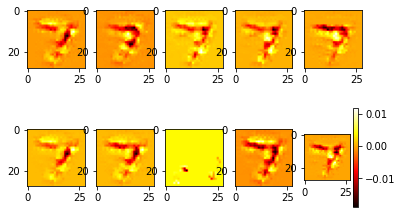

In [ ]:
for predictions in range(0,10):
  
  attribution = guided_gc.attribute(test_loader.dataset[0][0].reshape(1,1,28,28),predictions)
  plt.subplot(2,5,predictions+1)
  plt.imshow(attribution.detach().numpy().reshape(28,28),cmap=plt.cm.hot)
plt.colorbar()

# With Attention

In [31]:
class Net_Attention(nn.Module):
    def __init__(self):
        super(Net_Attention, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.bam=BAM(10,r=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x=self.bam(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [32]:
network = Net_Attention()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [33]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [34]:
network

Net_Attention(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (bam): BAM(
    (channel_att): ch_attention(
      (layers): Sequential(
        (0): AdaptiveAvgPool2d(output_size=(1, 1))
        (1): View()
        (2): Linear(in_features=10, out_features=2, bias=False)
        (3): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Linear(in_features=2, out_features=10, bias=True)
      )
    )
    (spatial_att): spatial_attention(
      (layers): Sequential(
        (0): Conv2d(10, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4), bias=False)
        (4): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(

In [35]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2853, Accuracy: 1396/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324827
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.301638
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.235379
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.275776
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.170403
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.048336
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.958936
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.889362
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.884098
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.823568
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.728887
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.649423
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.384680
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.212710
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.048029
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.032260
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.037698
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.998364
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.027012
Train Epoch: 1 [12160

In [36]:
test_losses[0:4]


[2.2853187744140624,
 0.1613461601257324,
 0.10610107498168946,
 0.0915973991394043]

Text(0, 0.5, 'negative log likelihood loss')

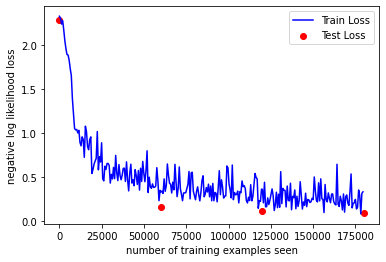

In [37]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses[0:4], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


In [38]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


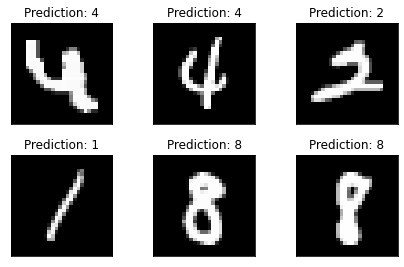

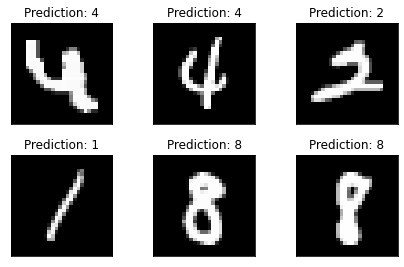

In [39]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
network.forward

2
6
3
9
6
9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


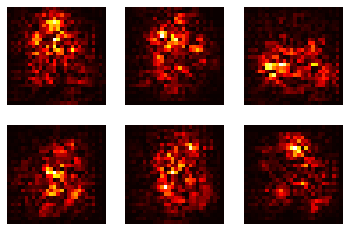

In [42]:


plot_saliencies=[1,100,200,1000,3000,4000]
i=1

# code to plot the saliency map as a heatmap
for s in plot_saliencies:
  plt.subplot(2,3,i)
  plt.imshow(saliency(s,network), cmap=plt.cm.hot)

  plt.axis('off')
  i+=1

plt.show()

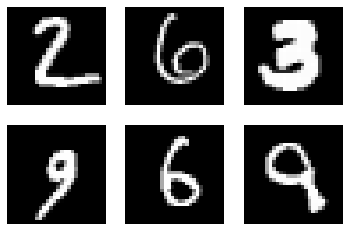

In [43]:
i=1
for s in plot_saliencies:
  plt.subplot(2,3,i)
  plt.imshow(test_loader.dataset[s][0].numpy().reshape(28,28), cmap="gray")

  plt.axis('off')
  i+=1

plt.show()

In [46]:
network


Net_Attention(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (bam): BAM(
    (channel_att): ch_attention(
      (layers): Sequential(
        (0): AdaptiveAvgPool2d(output_size=(1, 1))
        (1): View()
        (2): Linear(in_features=10, out_features=2, bias=False)
        (3): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Linear(in_features=2, out_features=10, bias=True)
      )
    )
    (spatial_att): spatial_attention(
      (layers): Sequential(
        (0): Conv2d(10, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4), bias=False)
        (4): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(

In [47]:
guided_gc=GuidedGradCam(network,network.conv2)

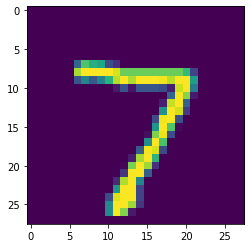

In [48]:
plt.imshow(test_loader.dataset[0][0].reshape(28,28))



/usr/local/lib/python3.6/dist-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


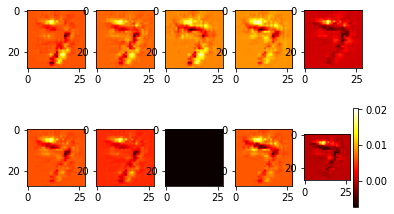

In [49]:
for predictions in range(0,10):
  
  attribution = guided_gc.attribute(test_loader.dataset[0][0].reshape(1,1,28,28),predictions)
  plt.subplot(2,5,predictions+1)
  plt.imshow(attribution.detach().numpy().reshape(28,28),cmap=plt.cm.hot)
plt.colorbar()

# Spatial Only


In [25]:
class Net_Attention_spatial(nn.Module):
    def __init__(self):
        super(Net_Attention_spatial, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.bam=BAM_spatial(10,r=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x=self.bam(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [26]:
network = Net_Attention_spatial()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [27]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [28]:
network

Net_Attention_spatial(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (bam): BAM_spatial(
    (spatial_att): spatial_attention(
      (layers): Sequential(
        (0): Conv2d(10, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4), bias=False)
        (4): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4), bias=False)
        (7): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
        (9): Conv2d(2, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
  )
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5

In [31]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3220, Accuracy: 1756/10000 (18%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.393227
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.301782
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.241446
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.186762
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.156144
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.086363
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.117015
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.984804
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.752488
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.469601
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.786050
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.340033
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.335121
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.082111
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.168788
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.224120
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.111022
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.072388
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.150286
Train Epoch: 1 [12160

In [ ]:
test_losses[0:4]


[2.2853187744140624,
 0.1613461601257324,
 0.10610107498168946,
 0.0915973991394043]

In [32]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses[0:4], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


NameError: ignored

In [ ]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


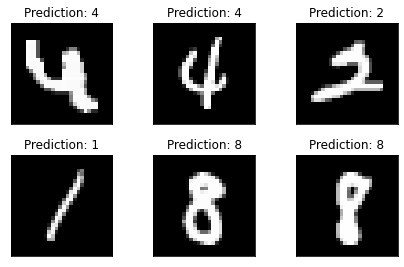

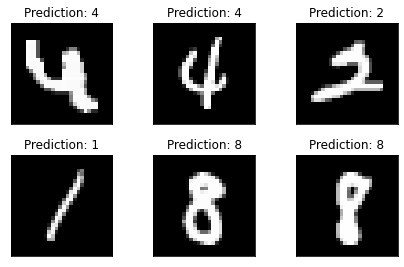

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
network.forward

2
6
3
9
6
9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


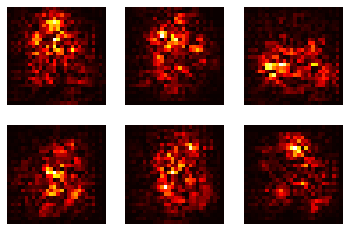

In [ ]:


plot_saliencies=[1,100,200,1000,3000,4000]
i=1

# code to plot the saliency map as a heatmap
for s in plot_saliencies:
  plt.subplot(2,3,i)
  plt.imshow(saliency(s,network), cmap=plt.cm.hot)

  plt.axis('off')
  i+=1

plt.show()

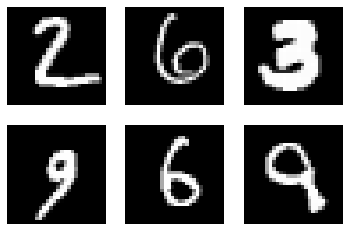

In [ ]:
i=1
for s in plot_saliencies:
  plt.subplot(2,3,i)
  plt.imshow(test_loader.dataset[s][0].numpy().reshape(28,28), cmap="gray")

  plt.axis('off')
  i+=1

plt.show()